<a href="https://colab.research.google.com/github/jayeshraj619/AI-LAB/blob/master/goodspi1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [263]:
df = pd.read_csv("/content/TEST.csv")
df

,month,avg R.HUM,avg temp,avg solar,sl1,spi1
0,01-05-1980,0.856281,22.978145,14.713567,-1.469306,-1.469306
1,01-06-1980,0.942733,23.261097,18.302932,-1.469306,0.364798
2,01-07-1980,0.903878,24.600967,21.047197,0.364798,0.606144
3,01-08-1980,0.882303,24.909726,20.217253,0.606144,0.606144
4,01-09-1980,0.833859,23.641217,13.403668,0.606144,1.001410
...,...,...,...,...,...,...
404,01-01-2014,0.682444,27.362823,21.104676,0.143235,0.317544
405,01-02-2014,0.783198,23.614450,12.783414,0.317544,0.546507
406,01-03-2014,0.946414,23.285097,11.613665,0.546507,0.629004
407,01-04-2014,0.959161,24.194050,21.052941,0.629004,0.174373


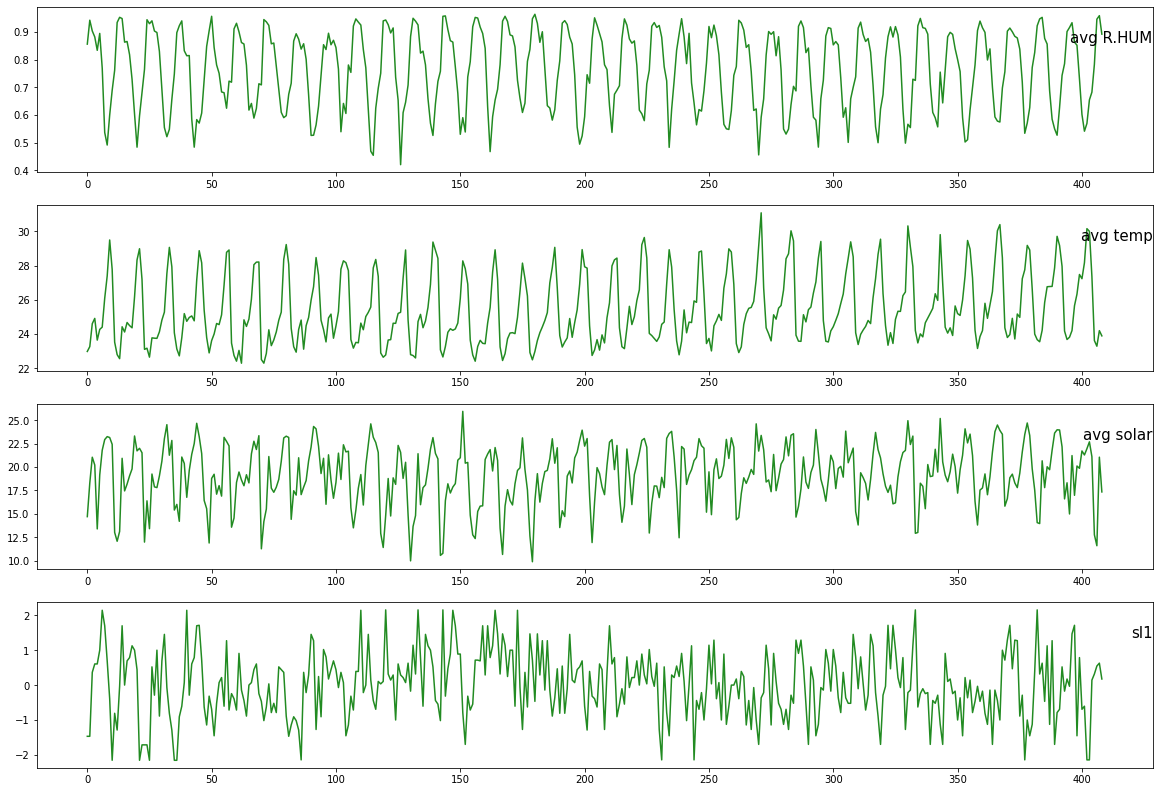

In [264]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 4]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

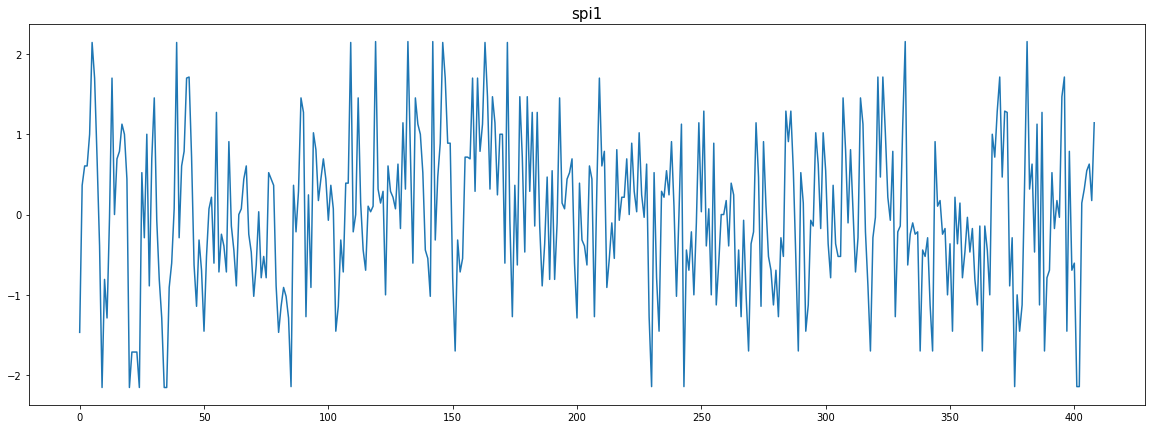

In [265]:
fig = plt.figure(figsize = (20,7))
plt.plot(df.spi1)
plt.title("spi1", fontsize = 15)
plt.show()

In [266]:
del df["month"]

In [267]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [268]:
# Scaling the entire dataset

dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(409, 5)


In [269]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 1,1 )
print(reframed.shape)

(408, 10)


In [270]:
print(reframed.head())

# Here, there are some unwanted data, which we don't want to predict, i.e here var2(t), var3(3), ....

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.801607   0.078166   0.299907   0.159405   0.159405  0.960588  0.110365   
2   0.960588   0.110365   0.523816   0.159405   0.584563  0.889136  0.262840   
3   0.889136   0.262840   0.695007   0.584563   0.640508  0.849461  0.297976   
4   0.849461   0.297976   0.643234   0.640508   0.640508  0.760374  0.153622   
5   0.760374   0.153622   0.218193   0.640508   0.732133  0.872728  0.224777   

    var3(t)   var4(t)   var5(t)  
1  0.523816  0.159405  0.584563  
2  0.695007  0.584563  0.640508  
3  0.643234  0.640508  0.640508  
4  0.218193  0.640508  0.732133  
5  0.577521  0.732133  0.997405  


In [271]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'],
      dtype='object')

In [272]:
# droping columns we don't want to predict

reframed.drop(reframed.columns[[0,1,2,3,4]], axis=1, inplace=True)
print(reframed.head())

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)
1  0.960588  0.110365  0.523816  0.159405  0.584563
2  0.889136  0.262840  0.695007  0.584563  0.640508
3  0.849461  0.297976  0.643234  0.640508  0.640508
4  0.760374  0.153622  0.218193  0.640508  0.732133
5  0.872728  0.224777  0.577521  0.732133  0.997405


In [273]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = 358

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(358, 1, 4) (358,) (50, 1, 4) (50,)


In [274]:
train.shape, test.shape, values.shape

((358, 5), (50, 5), (408, 5))

In [275]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU
from tensorflow.keras.models import Sequential

In [276]:
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=25, validation_split=0.2, verbose=2, shuffle=False)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 1000)              4020000   
                                                                 
 dropout_31 (Dropout)        (None, 1000)              0         
                                                                 
 dense_37 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 4,021,001
Trainable params: 4,021,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
12/12 - 3s - loss: 0.1723 - val_loss: 0.0427 - 3s/epoch - 237ms/step
Epoch 2/70
12/12 - 0s - loss: 0.0582 - val_loss: 0.0569 - 466ms/epoch - 39ms/step
Epoch 3/70
12/12 - 0s - loss: 0.0549 - val_loss: 0.0369 - 460ms/epoch - 38ms/step
Epoch 4/70
12/12 - 0s - loss: 0.0490 - val_loss: 0.0356 - 498ms

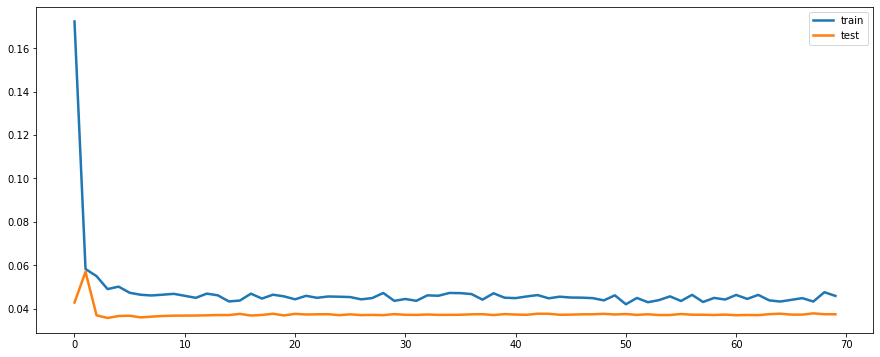

In [277]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [103]:
test_X.shape

(50, 1, 4)

In [278]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

(50, 1)
(50,)


In [ ]:
test.shape

(286, 5)

In [ ]:
print(test), print(test.shape)

In [279]:
y_test_true = test[:,4]

In [62]:
testPredict.shape

(50,)

In [280]:
poll = np.array(df['spi1'])
print(poll.shape)
meanop = poll.mean()
stdop = poll.std()
print(testPredict.shape)
y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

testPredict.shape

(409,)
(50,)


(50,)

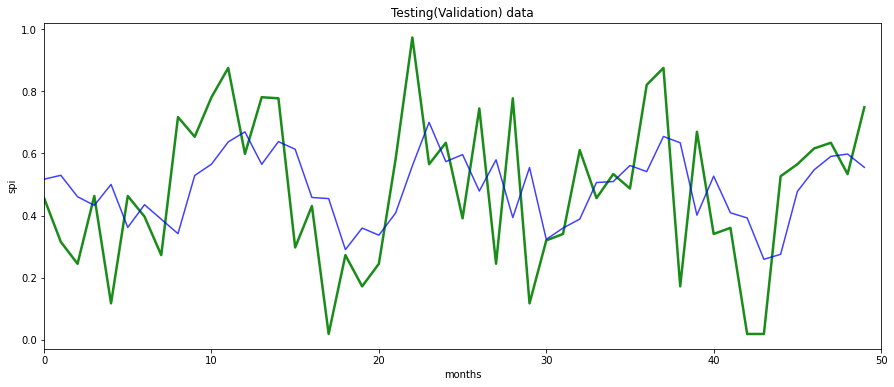

(50,)


In [281]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([0,50])
plt.ylabel("spi")
plt.xlabel("months")

plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()
#testPredict=testPredict.reshape(-1,1)
print(testPredict.shape)
#testTrue = scaler.inverse_transform(testPredict)

In [282]:
from sklearn.metrics import r2_score
r=r2_score(y_test_true, testPredict)
print("r2socre ="  ,r)
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test(Validation) RMSE ="  ,rmse)

# As we see the,  RMSE for testing data is low, and visually as well, from the above plots, we can see that the basic model is able to
# predict the future values of pollution (in ppm) pretty well

r2socre = 0.13028197024353305
Test(Validation) RMSE = 0.2255886
